In [2]:
from copy import copy
from functools import partial
import itertools
import json
from pathlib import Path
import re
import sys
sys.path.append("../src")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_notebook

%matplotlib inline
sns.set(style="whitegrid", context="paper", font_scale=3.5, rc={"lines.linewidth": 2.5})
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

## Data preparation

In [21]:
output_path = Path("../output")
decoder_path = output_path / "decoders"
bert_encoding_path = output_path / "encodings"
model_path = output_path / "bert"

In [9]:
checkpoints = [util.get_encoding_ckpt_id(dir_entry) for dir_entry in bert_encoding_path.iterdir()]

In [20]:
models = [model for model, _, _ in checkpoints]
standard_models = [model for model in models if not model.startswith("LM_")]
custom_models = [model for model in models if model.startswith("LM_")]

runs = sorted(set(run for _, run, _ in checkpoints))
checkpoint_steps = sorted(set(step for _, _, step in checkpoints))

# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_scrambled_para", "LM_pos", "glove"]

# Model subsets to render in different report figures
report_model_sets = [
    ("all", set(report_models)),
    ("standard", set(report_models) & set(standard_models)),
    ("custom", set(report_models) & set(custom_models)),
]

In [12]:
RENDER_FINAL = True
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True, parents=True)

report_hues = dict(zip(sorted(report_models), sns.color_palette()))

### Decoder performance metrics

In [15]:
# Load decoder performance data.
decoding_perfs = util.load_decoding_perfs(decoder_path)

Loading perf files: 100%|██████████| 176/176 [00:05<00:00, 32.50it/s]


In [16]:
# Save perf data.
decoding_perfs.to_csv(output_path / "decoder_perfs.csv")

In [17]:
# Load base decoder data.
# TODO refit to current setup -- need to add this decoder learning to pipeline ..
base_perfs = {}
base_perf_paths = list(Path("../models/decoders").glob("encodings-CLS.%s*.csv" % bert_base_model))
for base_decoder_perf_path in tqdm_notebook(base_perf_paths):
    subject, = re.findall(r"-([\w\d]+)\.csv$", base_decoder_perf_path.name)
    perf = pd.read_csv(base_decoder_perf_path,
                       usecols=["mse", "r2", "rank_median", "rank_mean", "rank_min", "rank_max"])
    base_perfs["_", 1, 0, subject] = perf
    
if len(base_perfs) == 0:
    raise RuntimeError("No base model performance found. Stop.")

NameError: name 'bert_base_model' is not defined

In [18]:
if base_perfs:
    decoding_perfs = \
        pd.concat([decoding_perfs,
                   pd.concat(base_perfs, names=["model", "run", "step", "subject"])])

In [19]:
# # Load comparison model data.
# for other_model in other_models:
#     other_perf_paths = list(Path("../models/decoders").glob("encodings.%s-*.csv" % other_model))
#     for other_perf_path in tqdm_notebook(other_perf_paths, desc=other_model):
#         subject, = re.findall(r"-([\w\d]+)\.csv$", other_perf_path.name)
#         perf = pd.read_csv(other_perf_path,
#                            usecols=["mse", "r2", "rank_median", "rank_mean", "rank_min", "rank_max"])
#         decoding_perfs.loc[other_model, 1, 250, subject] = perf.iloc[0]

### Model performance metrics

In [27]:
# For each model, load checkpoint data: global step, gradient norm information
model_metadata = {}
for model, run, step in tqdm_notebook(checkpoints):    
    # Fetch corresponding fine-tuning metadata.
    ckpt_path = model_path / ("%s-%i" % (model, run)) / ("model.ckpt-step%i" % step)
        
    if model == "_":
        model_dir = bert_path / bert_base_model
    else:
        model_dir = model_path / ("%s-%i" % (model, run))

    try:
        metadata = util.load_bert_finetune_metadata(model_dir, step)
    except Exception as e:
        pass
    else:
        if metadata["steps"]:
            model_metadata[model, target_run] = pd.DataFrame.from_dict(metadata["steps"], orient="index")

model_metadata = pd.concat(model_metadata, names=["model", "run", "step"])

Missing training events file in savedir: ../output/bert/SQuAD-1
Missing eval events data in savedir: ../output/bert/SQuAD-1
Missing training events file in savedir: ../output/bert/QQP-1
Missing eval events data in savedir: ../output/bert/QQP-1
Missing training events file in savedir: ../output/bert/MNLI-2
Missing eval events data in savedir: ../output/bert/MNLI-2
Missing training events file in savedir: ../output/bert/QQP-1
Missing eval events data in savedir: ../output/bert/QQP-1
Missing training events file in savedir: ../output/bert/QQP-2
Missing eval events data in savedir: ../output/bert/QQP-2
Missing training events file in savedir: ../output/bert/MNLI-1
Missing eval events data in savedir: ../output/bert/MNLI-1
Missing training events file in savedir: ../output/bert/MNLI-1
Missing eval events data in savedir: ../output/bert/MNLI-1
Missing training events file in savedir: ../output/bert/MNLI-2
Missing eval events data in savedir: ../output/bert/MNLI-2
Missing training events file

ValueError: No objects to concatenate

In [10]:
# SQuAD results need to be loaded separately from manual eval.
failed_runs = []
if "SQuAD" in bert_models:
    for target_run in tqdm(target_runs, desc="SQuAD run"):
        target_run_str = "" if target_run is None else "-run%i" % target_run
        model_dir = bert_path / ("%s.%s.SQuAD%s" % (finetune_desc, bert_base_model, target_run_str))
        if not model_dir.exists():
            continue

        for checkpoint_step in checkpoint_steps:
            pred_dir = model_dir / "predictions" / str(checkpoint_step)
            try:
                with (pred_dir / "results.json").open() as results_f:
                    results = json.load(results_f)
                model_metadata.loc["SQuAD", target_run, checkpoint_step]["eval_accuracy"] = \
                    results["best_f1"] / 100.
            except:
                failed_runs.append((target_run, checkpoint_step))
                
print("SQuAD eval failed for (run, step): ", failed_runs)

SQuAD run: 100%|██████████| 9/9 [00:12<00:00,  1.38s/it]

SQuAD eval failed for (run, step):  [(1, 5), (2, 5), (3, 5), (4, 5), (5, 135), (5, 140), (6, 5), (6, 10), (7, 5), (8, 5), (8, 10), (8, 15), (8, 20), (8, 25), (8, 30), (8, 35), (8, 40), (8, 45), (8, 50), (8, 55), (8, 60), (8, 65), (8, 70), (8, 75), (8, 80), (8, 85), (8, 90), (8, 95), (8, 100), (8, 105), (8, 110), (8, 115), (8, 120), (8, 125), (8, 130), (8, 135), (8, 140), (8, 145), (8, 150), (8, 155), (8, 160), (8, 165), (8, 170), (8, 175), (8, 180), (8, 185), (8, 190), (8, 195), (8, 200), (8, 205), (8, 210), (8, 215), (8, 220), (8, 225), (8, 230), (8, 235), (8, 240), (8, 245), (8, 250)]


### Putting it all together

In [46]:
# Join decoding data, post-hoc rank evaluation data, and model training metadata into a single df.
old_index = decoding_perfs.index
df = decoding_perfs.reset_index().join(model_metadata, on=["model", "run", "step"]).set_index(old_index.names)
df.head()

mse        r2  rank_mean  rank_median  rank_min  \
model run step subject                                                         
LM    1   0    M02      0.003514 -0.070840  41.341146         13.0       0.0   
               M04      0.003696 -0.067034  60.041667         26.0       0.0   
               M07      0.003556 -0.068090  45.723958         17.0       0.0   
               M08      0.003689 -0.068957  58.828125         28.0       0.0   
               M09      0.003688 -0.065191  54.505208         25.0       0.0   

                        rank_max  total_global_norms  train_loss  \
model run step subject                                             
LM    1   0    M02         343.0                 NaN         NaN   
               M04         353.0                 NaN         NaN   
               M07         379.0                 NaN         NaN   
               M08         378.0                 NaN         NaN   
               M09         342.0                 NaN         NaN   

                        train_loss_norm  eval_accuracy  eval_loss  
model run step subject                                             
LM    1   0    M02                  NaN            NaN        NaN  
               M04                  NaN            NaN        NaN  
               M07                  NaN            NaN        NaN  
               M08                  NaN            NaN        NaN  
               M09                  NaN            NaN        NaN

-----------

In [47]:
all_subjects = df.index.get_level_values("subject").unique()
all_subjects

Index(['M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15', 'P01'], dtype='object', name='subject')

In [48]:
subjects_with_baseline = set(decoding_perfs.loc["_", :, :].index.get_level_values("subject"))
if not subjects_with_baseline == set(all_subjects):
    raise ValueError("Missing base decoder evaluation for subjects: " + str(set(all_subjects) - subjects_with_baseline))

### Synthetic columns

In [49]:
df["eval_accuracy_delta"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda xs: xs - xs.iloc[0])
df["eval_accuracy_norm"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda accs: (accs - accs.min()) / (accs.max() - accs.min()))

In [50]:
def decoding_perf_delta(xs, metric="mse"):
    subject = xs.index[0][3]
    base_metric = df.loc["_", 1, 0, subject][metric]
    return xs - base_metric.item()

df["decoding_mse_delta"] = df.groupby(["model", "run", "subject"]).mse.transform(partial(decoding_perf_delta, metric="mse"))
df["rank_mean_delta"] = df.groupby(["model", "run", "subject"]).rank_mean.transform(partial(decoding_perf_delta, metric="rank_mean"))
df["rank_median_delta"] = df.groupby(["model", "run", "subject"]).rank_median.transform(partial(decoding_perf_delta, metric="rank_median"))

In [51]:
NUM_BINS = 50
def bin(xs):
    if xs.isnull().values.any(): return np.nan
    return pd.cut(xs, np.linspace(xs.min(), xs.max() + 1e-5, NUM_BINS), labels=False)
df["eval_accuracy_bin"] = df.groupby(["model"]).eval_accuracy.transform(bin)
df["decoding_mse_bin"] = df.groupby(["subject"]).decoding_mse_delta.transform(bin)
df["total_global_norms_bin"] = df.groupby(["model"]).total_global_norms.transform(bin)

In [52]:
ROLLING_WINDOW_SIZE = 5
grouped = df.groupby(["model", "run", "subject"])
for col in ["mse", "decoding_mse_delta", "eval_accuracy", "train_loss", "rank_mean", "rank_mean_delta"]:
    df["%s_rolling" % col] = grouped[col].transform(lambda rows: rows.rolling(ROLLING_WINDOW_SIZE, min_periods=1).mean())

In [53]:
df.tail()

mse        r2  rank_mean  rank_median  rank_min  \
model run step subject                                                         
glove 1   250  M08      0.003592 -0.069331  47.283854         21.5       0.0   
               M09      0.003656 -0.069032  55.739583         26.0       0.0   
               M14      0.003736 -0.068638  68.328125         33.0       0.0   
               M15      0.003535 -0.061499  40.890625         17.0       0.0   
               P01      0.003337 -0.064256  24.380208          8.0       0.0   

                        rank_max  total_global_norms  train_loss  \
model run step subject                                             
glove 1   250  M08         379.0                 NaN         NaN   
               M09         375.0                 NaN         NaN   
               M14         371.0                 NaN         NaN   
               M15         380.0                 NaN         NaN   
               P01         285.0                 NaN         NaN   

                        train_loss_norm  eval_accuracy  \
model run step subject                                   
glove 1   250  M08                  NaN            NaN   
               M09                  NaN            NaN   
               M14                  NaN            NaN   
               M15                  NaN            NaN   
               P01                  NaN            NaN   

                                 ...             rank_median_delta  \
model run step subject           ...                                 
glove 1   250  M08               ...                         -10.5   
               M09               ...                           1.0   
               M14               ...                          -9.5   
               M15               ...                           0.0   
               P01               ...                          -6.5   

                        eval_accuracy_bin  decoding_mse_bin  \
model run step subject                                        
glove 1   250  M08                    NaN              15.0   
               M09                    NaN              17.0   
               M14                    NaN              24.0   
               M15                    NaN              13.0   
               P01                    NaN              11.0   

                        total_global_norms_bin  mse_rolling  \
model run step subject                                        
glove 1   250  M08                         NaN     0.003592   
               M09                         NaN     0.003656   
               M14                         NaN     0.003736   
               M15                         NaN     0.003535   
               P01                         NaN     0.003337   

                        decoding_mse_delta_rolling  eval_accuracy_rolling  \
model run step subject                                                      
glove 1   250  M08                       -0.000095                    NaN   
               M09                       -0.000067                    NaN   
               M14                       -0.000038                    NaN   
               M15                       -0.000027                    NaN   
               P01                       -0.000128                    NaN   

                        train_loss_rolling  rank_mean_rolling  \
model run step subject                                          
glove 1   250  M08                     NaN          47.283854   
               M09                     NaN          55.739583   
               M14                     NaN          68.328125   
               M15                     NaN          40.890625   
               P01                     NaN          24.380208   

                        rank_mean_delta_rolling  
model run step subject                           
glove 1   250  M08                   -12.794271  
               M09                    -7.843750  
             

In [54]:
df.head()

mse        r2  rank_mean  rank_median  rank_min  \
model run step subject                                                         
LM    1   0    M02      0.003514 -0.070840  41.341146         13.0       0.0   
               M04      0.003696 -0.067034  60.041667         26.0       0.0   
               M07      0.003556 -0.068090  45.723958         17.0       0.0   
               M08      0.003689 -0.068957  58.828125         28.0       0.0   
               M09      0.003688 -0.065191  54.505208         25.0       0.0   

                        rank_max  total_global_norms  train_loss  \
model run step subject                                             
LM    1   0    M02         343.0                 NaN         NaN   
               M04         353.0                 NaN         NaN   
               M07         379.0                 NaN         NaN   
               M08         378.0                 NaN         NaN   
               M09         342.0                 NaN         NaN   

                        train_loss_norm  eval_accuracy  \
model run step subject                                   
LM    1   0    M02                  NaN            NaN   
               M04                  NaN            NaN   
               M07                  NaN            NaN   
               M08                  NaN            NaN   
               M09                  NaN            NaN   

                                 ...             rank_median_delta  \
model run step subject           ...                                 
LM    1   0    M02               ...                           0.0   
               M04               ...                           2.0   
               M07               ...                           0.0   
               M08               ...                          -4.0   
               M09               ...                           0.0   

                        eval_accuracy_bin  decoding_mse_bin  \
model run step subject                                        
LM    1   0    M02                    NaN              17.0   
               M04                    NaN              24.0   
               M07                    NaN              17.0   
               M08                    NaN              24.0   
               M09                    NaN              19.0   

                        total_global_norms_bin  mse_rolling  \
model run step subject                                        
LM    1   0    M02                         NaN     0.003514   
               M04                         NaN     0.003696   
               M07                         NaN     0.003556   
               M08                         NaN     0.003689   
               M09                         NaN     0.003688   

                        decoding_mse_delta_rolling  eval_accuracy_rolling  \
model run step subject                                                      
LM    1   0    M02                    1.848142e-06                    NaN   
               M04                    2.457603e-05                    NaN   
               M07                   -8.336684e-07                    NaN   
               M08                    2.744136e-06                    NaN   
               M09                   -3.491807e-05                    NaN   

                        train_loss_rolling  rank_mean_rolling  \
model run step subject                                          
LM    1   0    M02                     NaN          41.341146   
               M04                     NaN          60.041667   
               M07                     NaN          45.723958   
               M08                     NaN          58.828125   
               M09                     NaN          54.505208   

                        rank_mean_delta_rolling  
model run step subject                           
LM    1   0    M02                     0.343750  
               M04                     4.328125  
             

In [55]:
dfi = df.reset_index()

## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

In [56]:
# g = sns.FacetGrid(df.reset_index().melt(id_vars=["model", "run", "step"],
#                                         value_vars=["train_loss_rolling", "eval_accuracy_rolling"]),
#                   row="variable", col="model", sharex=True, sharey=False, height=4)
# g.map(sns.lineplot, "step", "value", "run", ci=None)
# g.add_legend()

In [122]:
%matplotlib agg

if RENDER_FINAL:
    # models which appear on left edge of subfigs in paper
    LEFT_EDGE_MODELS = ["QQP", "LM"]
    
    training_fig_path = figure_path / "training"
    training_fig_path.mkdir(exist_ok=True)
    shared_kwargs = {"legend": False, "ci": None}

    for model in tqdm_notebook(report_models):
        f, (loss_fig, acc_fig) = plt.subplots(2, 1, figsize=(10,15), sharex=True)
        try:
            local_data = df.loc[model].reset_index()
        except KeyError:
            print(f"Missing training data for {model}")
            continue
            
        ax = sns.lineplot(data=local_data, x="step", y="train_loss_rolling", hue="run", ax=loss_fig, **shared_kwargs)
        ax.set_ylabel("Training loss\n(rolling window)" if model in LEFT_EDGE_MODELS else "")
        ax.set_xlabel("Training step")
        
        ax = sns.lineplot(data=local_data, x="step", y="eval_accuracy_rolling", hue="run", ax=acc_fig, **shared_kwargs)
        ax.set_ylabel("Validation set accuracy\n(rolling window)" if model in LEFT_EDGE_MODELS else "")
        ax.set_xlabel("Training step")
        
        sns.despine()
        
        plt.tight_layout()
        plt.savefig(training_fig_path / ("%s.pdf" % model))
        plt.close()
%matplotlib inline

## Decoding analyses

In [123]:
MSE_DELTA_LABEL = "$\Delta$(MSE)"
MAR_DELTA_LABEL = "$\Delta$(MAR)"

### Final state analysis

In [124]:
%matplotlib agg

if RENDER_FINAL:
    final_state_fig_path = figure_path / "final_state"
    final_state_fig_path.mkdir(exist_ok=True)
    metrics = [("decoding_mse_delta", MSE_DELTA_LABEL, None, None),
               ("rank_mean_delta", MAR_DELTA_LABEL, None, None),
               ("mse", "Mean squared error", 0.00335, 0.00385),
               ("rank_mean", "Mean average rank", 20, 95)]
    
    for model_set_name, model_set in report_model_sets:
        final_df = dfi[(dfi.step == checkpoint_steps[-1]) & (dfi.model.isin(model_set))]
        if final_df.empty:
            continue

        for metric, label, ymin, ymax in tqdm_notebook(metrics, desc=model_set_name):
            fig, ax = plt.subplots(figsize=(15, 10))

            # Plot BERT baseline performance.
            if "delta" not in metric:
                # TODO error region instead -- plt.fill_between
                ax.axhline(dfi[dfi.model == "_"][metric].mean(), linestyle="--", color="gray")

            sns.barplot(data=final_df, x="model", y=metric,
                        order=final_df.groupby("model")[metric].mean().sort_values().index,
                        palette=report_hues, ax=ax)

            padding = final_df[metric].var() * 0.005
            plt.ylim((ymin or (final_df[metric].min() - padding), ymax or (final_df[metric].max() + padding)))
            plt.xlabel("Model")
            plt.ylabel(label)
            plt.xticks(rotation=45, ha="right")

            plt.tight_layout()
            plt.savefig(final_state_fig_path / (f"{metric}.{model_set_name}.pdf"))
            #plt.close(fig)
        
%matplotlib inline

In [125]:
%matplotlib agg

if RENDER_FINAL:
    final_state_fig_path = figure_path / "final_state_within_subject"
    final_state_fig_path.mkdir(exist_ok=True)
    metrics = [("decoding_mse_delta", MSE_DELTA_LABEL),
               ("rank_mean_delta", MAR_DELTA_LABEL),
               ("mse", "Mean squared error"),
               ("rank_mean", "Mean average rank")]
    
    for model_set_name, model_set in report_model_sets:
        final_df = dfi[(dfi.step == checkpoint_steps[-1]) & (dfi.model.isin(model_set))]

        for metric, label in tqdm_notebook(metrics, desc=model_set_name):
            fig = plt.figure(figsize=(25, 10))
            sns.barplot(data=final_df, x="model", y=metric, hue="subject",
                        order=final_df.groupby("model")[metric].mean().sort_values().index)
            plt.ylabel(label)
            plt.xticks(rotation=30, ha="right")
            plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
            plt.tight_layout()
            plt.savefig(final_state_fig_path / f"{metric}.{model_set_name}.pdf")
            plt.close(fig)
    
%matplotlib inline

In [188]:
%matplotlib agg

if RENDER_FINAL:
    final_state_fig_path = figure_path / "final_state_within_model"
    final_state_fig_path.mkdir(exist_ok=True)
    metrics = [("decoding_mse_delta", MSE_DELTA_LABEL, None, None),
               ("rank_mean_delta", MAR_DELTA_LABEL, None, None),
               ("mse", "Mean squared error", None, None),
               ("rank_mean", "Mean average rank", None, None)]
    
    subj_order = dfi[(dfi.step == checkpoint_steps[-1]) & (dfi.model.isin(report_model_sets[0][1]))] \
        .groupby("subject")[metrics[0][0]].mean().sort_values().index
    
    for model_set_name, model_set in report_model_sets:
        final_df = dfi[(dfi.step == checkpoint_steps[-1]) & (dfi.model.isin(model_set))]

        for metric, label, ymin, ymax in tqdm_notebook(metrics, desc=model_set_name):
            fig = plt.figure(figsize=(25, 10))
            sns.barplot(data=final_df, x="subject", y=metric, hue="model",
                        order=subj_order)
            
            padding = final_df[metric].var() * 0.005
            plt.ylim((ymin or (final_df[metric].min() - padding), ymax or (final_df[metric].max() + padding)))
            plt.xlabel("Subject")
            plt.ylabel(label)
            
            plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
            plt.tight_layout()
            plt.savefig(final_state_fig_path / f"{metric}.{model_set_name}.pdf")
            plt.close(fig)
    
%matplotlib inline

### Step analysis

In [126]:
# g = sns.FacetGrid(dfi, col="run", size=6)
# g.map(sns.lineplot, "step", "decoding_mse_delta", "model").add_legend()

# plt.xlabel("Fine-tuning step")
# plt.ylabel(MSE_DELTA_LABEL)

In [127]:
# g = sns.FacetGrid(dfi, col="run", size=6)
# g.map(sns.lineplot, "step", "rank_mean_delta", "model").add_legend()

# plt.xlabel("Fine-tuning step")
# plt.ylabel(MAR_DELTA_LABEL)

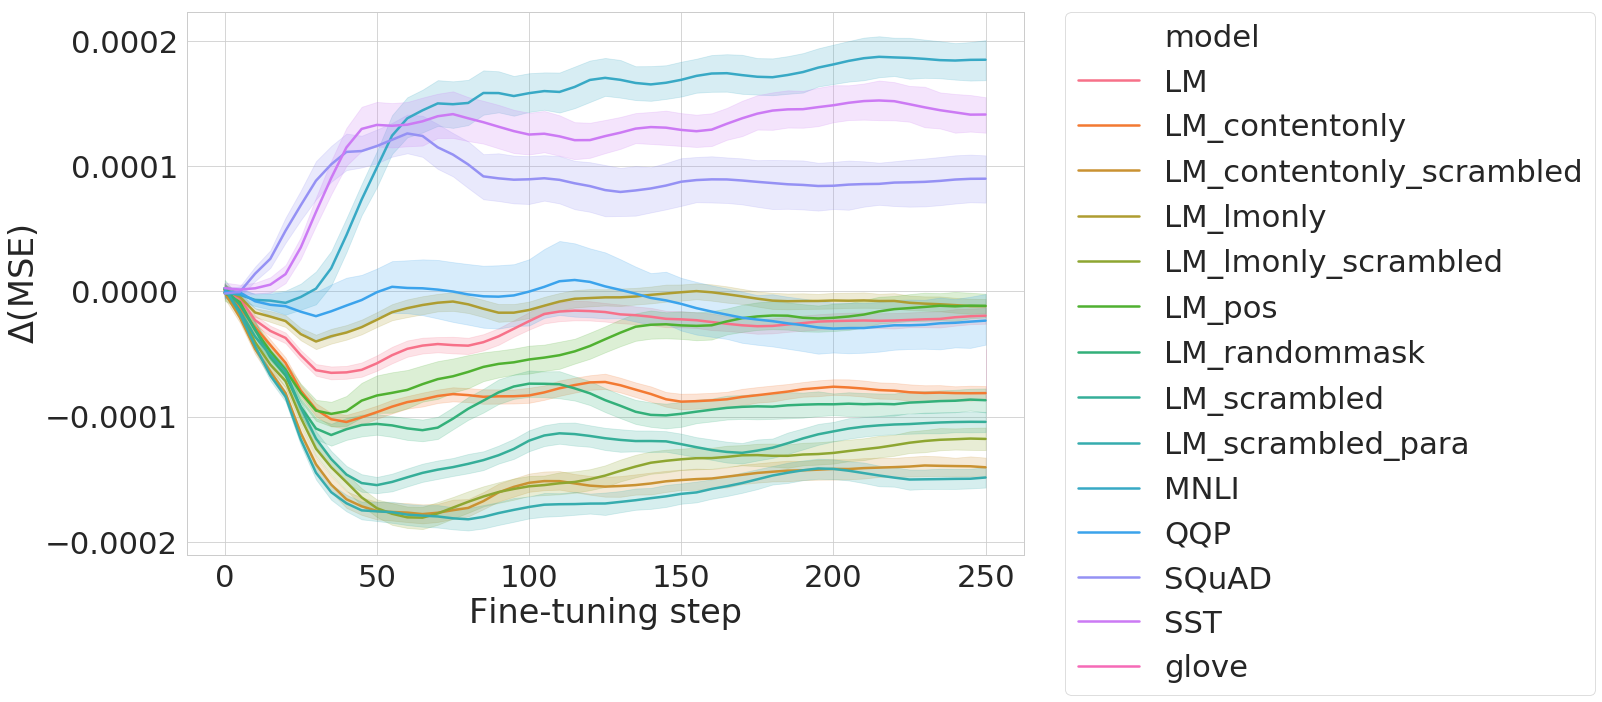

In [128]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi, x="step", y="decoding_mse_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

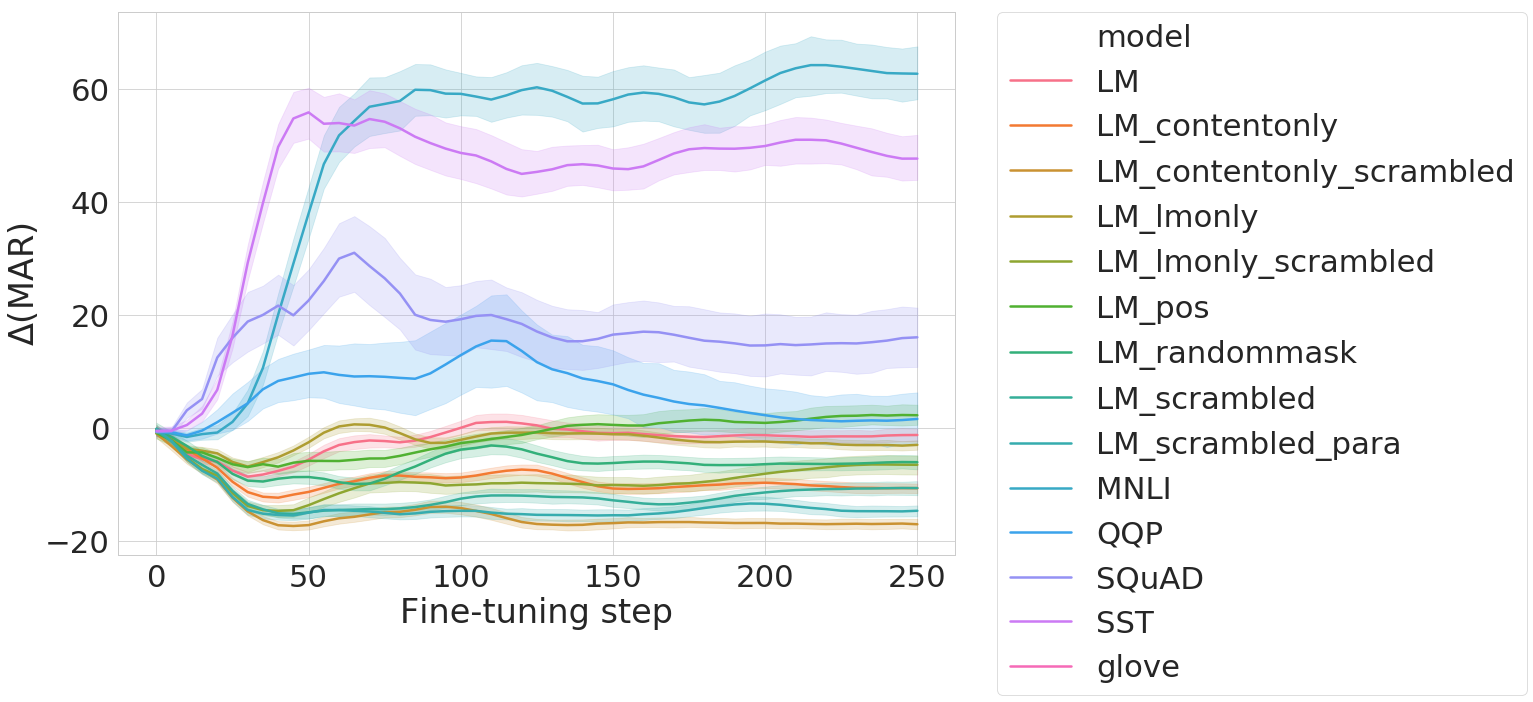

In [129]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi, x="step", y="rank_mean_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0,0.5,'$\\Delta$(MSE)')

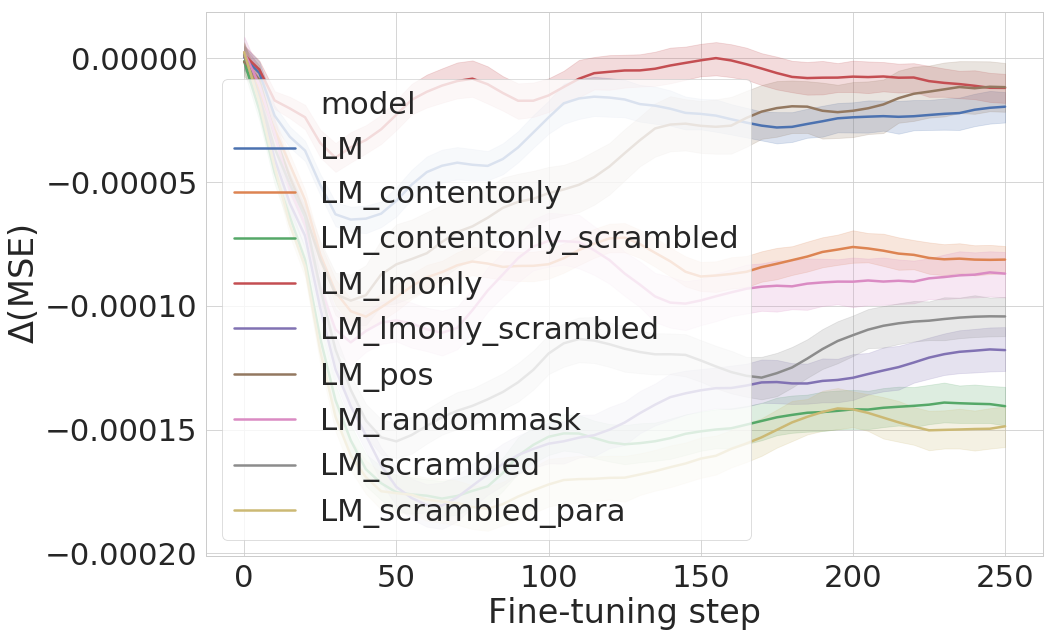

In [130]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi[dfi.model.str.startswith("LM")], x="step", y="decoding_mse_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)

Text(0,0.5,'$\\Delta$(MAR)')

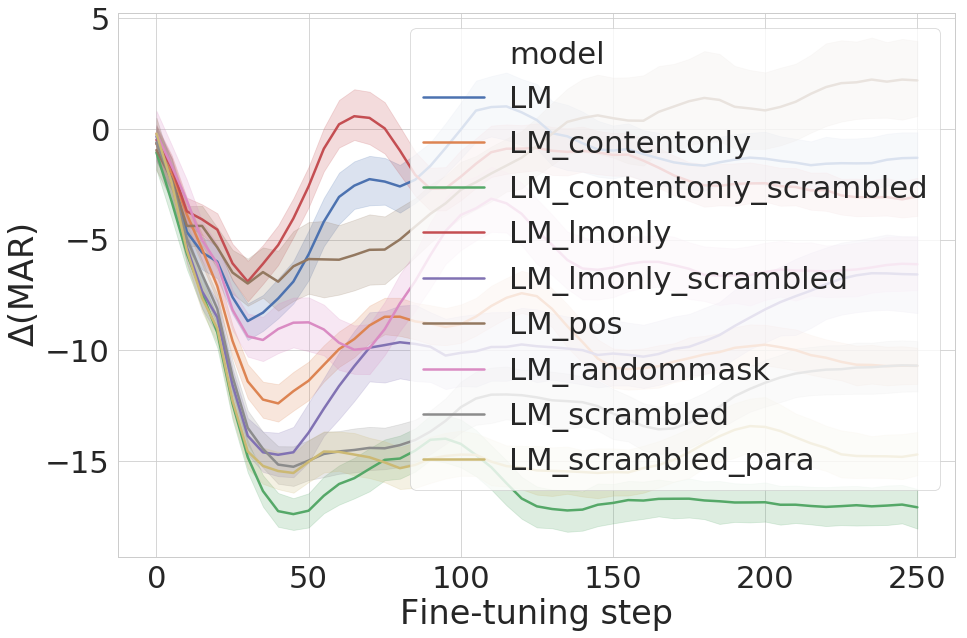

In [131]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi[dfi.model.str.startswith("LM")], x="step", y="rank_mean_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

In [132]:
%matplotlib agg

if RENDER_FINAL:
    trajectory_fig_dir = figure_path / "trajectories"
    trajectory_fig_dir.mkdir(exist_ok=True)
    metrics = [("decoding_mse_delta", MSE_DELTA_LABEL),
               ("rank_mean_delta", MAR_DELTA_LABEL),
               ("decoding_mse_delta_rolling", MSE_DELTA_LABEL),
               ("rank_mean_delta_rolling", MAR_DELTA_LABEL)]

    for model_set_name, model_set in report_model_sets:
        for metric, label in tqdm_notebook(metrics, desc=model_set_name):
            fig = plt.figure(figsize=(18, 10))
            sns.lineplot(data=dfi[dfi.model.isin(model_set) & (~dfi.model.isin(other_models))],
                         x="step", y=metric, hue="model", palette=report_hues)
            plt.xlim((0, checkpoint_steps[-1]))
            plt.xlabel("Fine-tuning step")
            plt.ylabel(label)
            plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.savefig(trajectory_fig_dir / f"{metric}.{model_set_name}.pdf")
            plt.close(fig)
    
%matplotlib inline

In [133]:
# g = sns.FacetGrid(dfi[dfi.model != "_"], col="model", row="run", size=6)
# g.map(sns.lineplot, "step", "decoding_mse_delta", "subject", ci=None).add_legend()

In [134]:
# g = sns.FacetGrid(dfi, col="model", row="run", size=6)
# g.map(sns.lineplot, "step", "rank_median_delta", "subject", ci=None).add_legend()

### Gradient norm analysis

In [135]:
# f, ax = plt.subplots(figsize=(10, 8))
# sns.lineplot(data=dfi, y="decoding_mse_delta", x="total_global_norms_bin", hue="model", ax=ax)
# ax.set_title("Decoding performance delta vs. binned total global gradient norm")
# ax.set_xlabel("Cumulative global gradient norm bin")
# ax.set_ylabel(MSE_DELTA_LABEL)

In [136]:
#g = sns.FacetGrid(dfi, col="model", row="run", size=6, sharex=False, sharey=True)
#g.map(sns.lineplot, "total_global_norms", "decoding_mse_delta", "subject", ci=None).add_legend()

### Eval accuracy analysis

In [137]:
#g = sns.FacetGrid(dfi, col="model", row="run", sharex=False, sharey=True, size=7)
#g.map(sns.lineplot, "eval_accuracy", "decoding_mse_delta", "subject", ci=None).add_legend()

## Per-subject analysis

Text(0.5,1,'subject final decoding mse delta, averaging across runs')

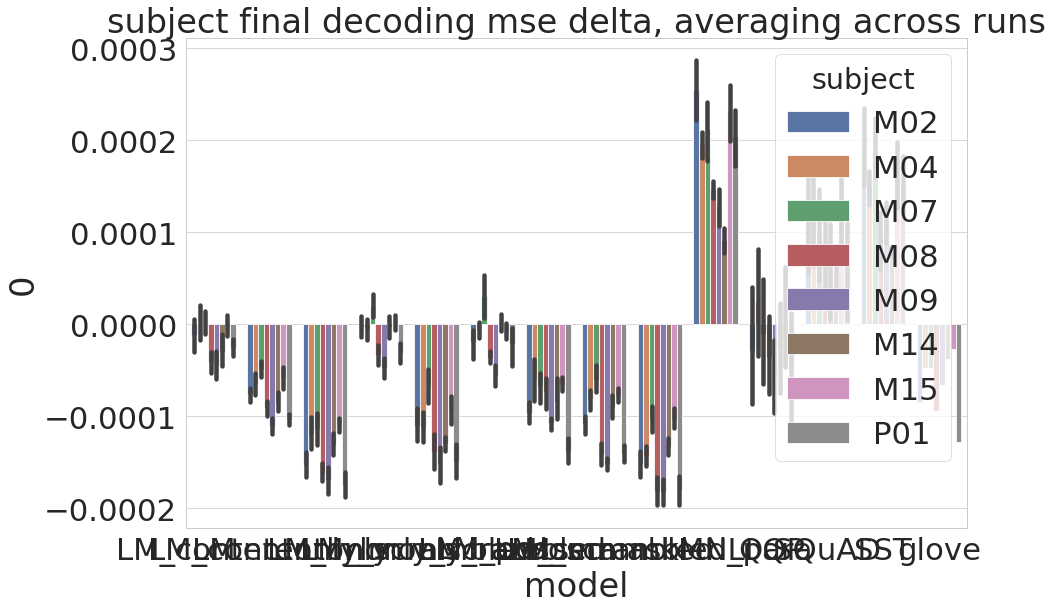

In [138]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi[dfi.step == checkpoint_steps[-1]].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.mean()).stack()).reset_index()
sns.barplot(data=dff, x="model", hue="subject", y=0, ax=ax)
plt.title("subject final decoding mse delta, averaging across runs")

Text(0.5,1,'subject final rank mean delta, averaging across runs')

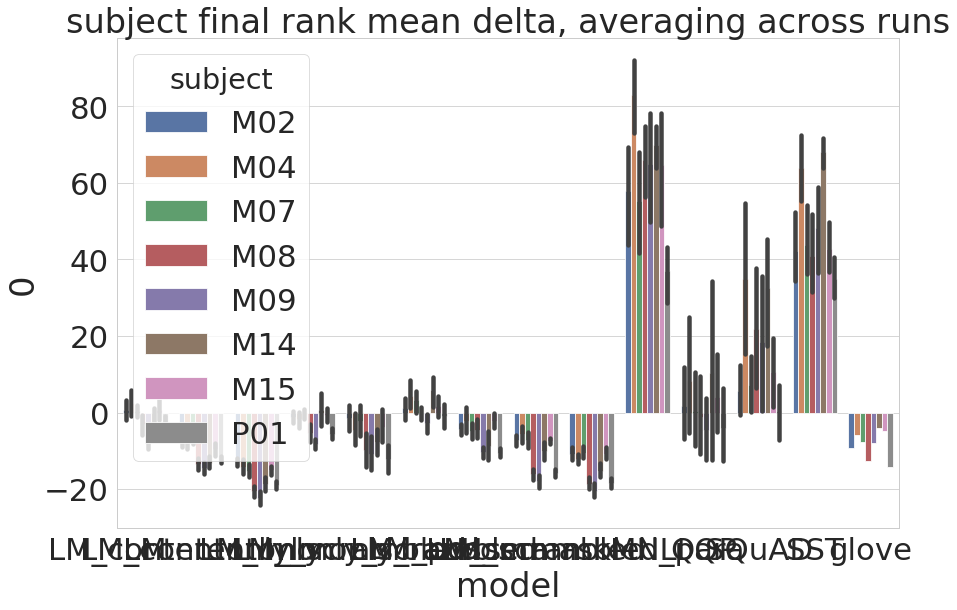

In [139]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi[dfi.step == checkpoint_steps[-1]].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").rank_mean_delta.mean()).stack()).reset_index()
sns.barplot(data=dff, x="model", hue="subject", y=0, ax=ax)
plt.title("subject final rank mean delta, averaging across runs")

Text(0.5,1,'subject max decoding mse delta, averaging across models and runs')

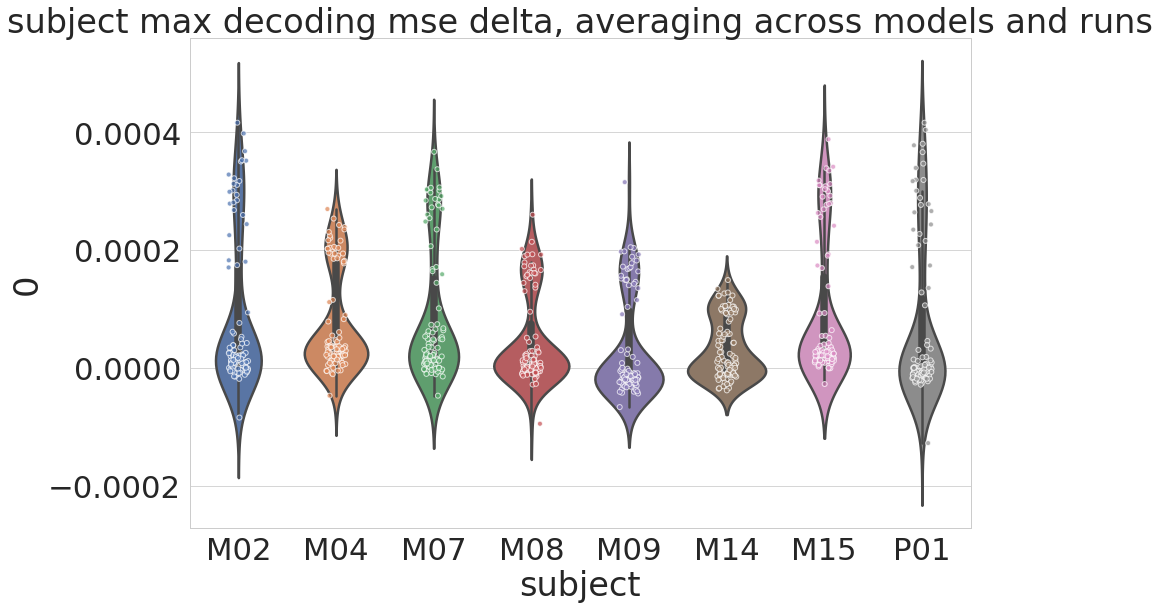

In [140]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.max()).stack()).reset_index()
sns.violinplot(data=dff, x="subject", y=0)
sns.stripplot(data=dff, x="subject", y=0, edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject max decoding mse delta, averaging across models and runs")

Text(0.5,1,'subject min decoding mse delta, averaging across models and runs')

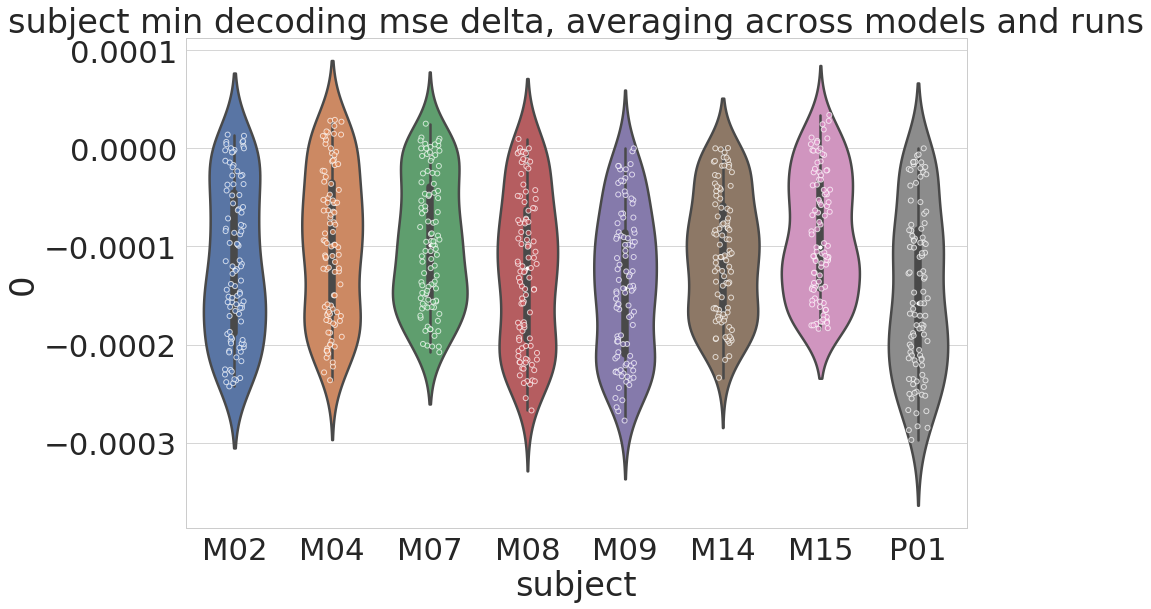

In [141]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.min()).stack()).reset_index()
sns.violinplot(data=dff, x="subject", y=0)
sns.stripplot(data=dff, x="subject", y=0, edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject min decoding mse delta, averaging across models and runs")

## Statistical analyses

First, some data prep for comparing final vs. start states:

In [142]:
perf_comp = df.query("step == %i" % checkpoint_steps[-1]).reset_index(level="step", drop=True).sort_index()
# Join data from baseline
perf_comp = perf_comp.join(df.loc["_", 1, 0].rename(columns=lambda c: "start_%s" % c))
perf_comp = perf_comp.join(df.loc["glove", 1, 250].rename(columns=lambda c: "glove_%s" % c))
perf_comp.head()

mse        r2  rank_mean  rank_median  rank_min  \
model run subject                                                         
LM    1   M02      0.003516 -0.067171  41.856771         14.5       0.0   
          M04      0.003651 -0.066304  52.994792         21.0       0.0   
          M07      0.003568 -0.066919  45.781250         18.5       0.0   
          M08      0.003634 -0.064264  54.101562         23.5       0.0   
          M09      0.003666 -0.064481  53.294271         23.0       0.0   

                   rank_max  total_global_norms  train_loss  train_loss_norm  \
model run subject                                                              
LM    1   M02         358.0          440.755916    2.165702              NaN   
          M04         342.0          440.755916    2.165702              NaN   
          M07         370.0          440.755916    2.165702              NaN   
          M08         372.0          440.755916    2.165702              NaN   
          M09         349.0          440.755916    2.165702              NaN   

                   eval_accuracy              ...                \
model run subject                             ...                 
LM    1   M02           0.627797              ...                 
          M04           0.627797              ...                 
          M07           0.627797              ...                 
          M08           0.627797              ...                 
          M09           0.627797              ...                 

                   glove_rank_median_delta  glove_eval_accuracy_bin  \
model run subject                                                     
LM    1   M02                         -2.0                      NaN   
          M04                         -2.0                      NaN   
          M07                         -3.0                      NaN   
          M08                        -10.5                      NaN   
          M09                          1.0                      NaN   

                   glove_decoding_mse_bin  glove_total_global_norms_bin  \
model run subject                                                         
LM    1   M02                        11.0                           NaN   
          M04                        17.0                           NaN   
          M07                        13.0                           NaN   
          M08                        15.0                           NaN   
          M09                        17.0                           NaN   

                   glove_mse_rolling  glove_decoding_mse_delta_rolling  \
model run subject                                                        
LM    1   M02               0.003428                         -0.000084   
          M04               0.003624                         -0.000047   
          M07               0.003510                         -0.000047   
          M08               0.003592                         -0.000095   
          M09               0.003656                         -0.000067   

                   glove_eval_accuracy_rolling  glove_train_loss_rolling  \
model run subject                                                          
LM    1   M02                              NaN                       NaN   
          M04                              NaN                       NaN   
          M07                              NaN                       NaN   
          M08                              NaN                       NaN   
          M09                              NaN                       NaN   

                   glove_rank_mean_rolling  glove_rank_mean_delta_rolling  
model run subject                                                          
LM    1   M02                    31.763021                      -9.234375  
          M04                    49.835938                      -5.877604  
          M07                    39.591146                      -7.664063  
          M

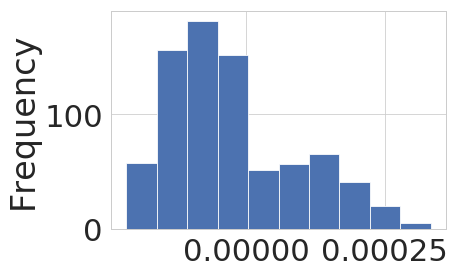

In [143]:
(perf_comp.mse - perf_comp.start_mse).plot.hist()

In [144]:
perf_compi = perf_comp.reset_index()

Quantitative tests:
 
1. for any GLUE task g, MSE(g after 250) > MSE(LM)
2. for any LM_scrambled_para task t, MSE(t after 250) < MSE(LM)
3. for any GLUE task g, MAR(g after 250) > MAR(LM)
4. for any LM_scrambled_para task t, MAR(t after 250) < MAR(LM)
5. MSE(LM after 250) =~ MSE(LM)
6. MAR(LM after 250) =~ MSE(LM)
7. for any LM_scrambled_para task t, MSE(t after 250) < MSE(glove)
8. for any LM_scrambled_para task t, MAR(t after 250) < MAR(glove)
9. for any LM_pos task t, MSE(t after 250) > MSE(LM)
10. for any LM_pos task t, MAR(t after 250) > MAR(LM)

### test 1

In [193]:
sample = perf_compi[~perf_compi.model.str.startswith(("_", "LM", "glove"))]

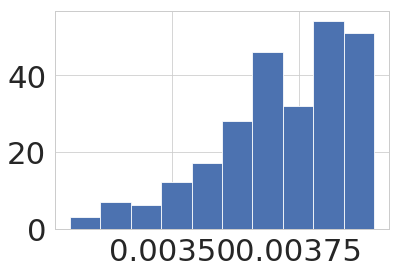

In [194]:
sample.mse.hist()

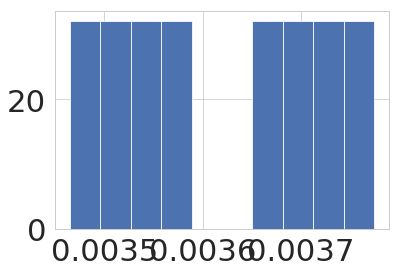

In [195]:
sample.start_mse.hist()

In [196]:
st.ttest_rel(sample.mse, sample.start_mse)

Ttest_relResult(statistic=14.844269632815486, pvalue=2.3858231250110423e-36)

### test 1 (split across models)

In [207]:
results = []
for model in standard_models:
    if model in ["LM", "glove"]: continue
    sample = perf_compi[perf_compi.model == model]
    results.append((model,) + st.ttest_rel(sample.mse, sample.start_mse))
    
pd.DataFrame(results, columns=["model", "tval", "pval"])

,model,tval,pval
0,SQuAD,9.160330,3.421660e-13
1,QQP,-2.212586,3.055832e-02
2,MNLI,22.943654,2.724859e-32
3,SST,19.098243,6.775895e-28


### test 2

In [149]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

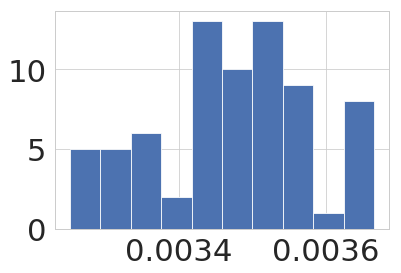

In [150]:
sample.mse.hist()

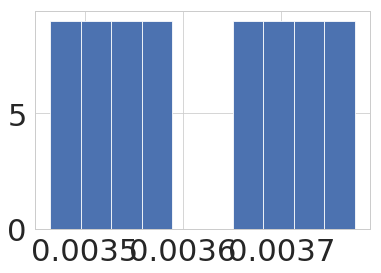

In [151]:
sample.start_mse.hist()

In [152]:
st.ttest_rel(sample.mse, sample.start_mse)

Ttest_relResult(statistic=-33.608235650779314, pvalue=2.4535080141919932e-45)

### test 3

In [208]:
sample = perf_compi[~perf_compi.model.str.startswith(("_", "LM", "glove"))]

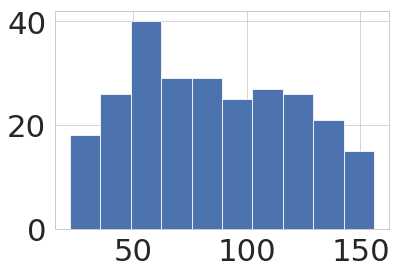

In [209]:
sample.rank_mean.hist()

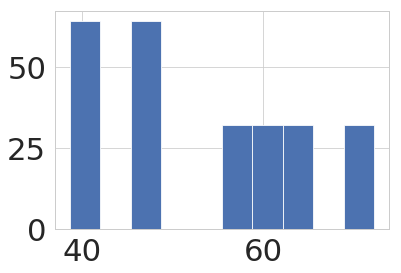

In [210]:
sample.start_rank_mean.hist()

In [211]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)

Ttest_relResult(statistic=16.546460754073816, pvalue=2.8534154361444523e-42)

### test 3 (split across models)

In [212]:
results = []
for model in standard_models:
    if model in ["LM", "glove"]: continue
    sample = perf_compi[perf_compi.model == model]
    results.append((model,) + st.ttest_rel(sample.rank_mean, sample.start_rank_mean))
    
pd.DataFrame(results, columns=["model", "tval", "pval"])

,model,tval,pval
0,SQuAD,5.784662,2.458139e-07
1,QQP,0.794558,4.298536e-01
2,MNLI,24.639735,4.751012e-34
3,SST,23.419462,8.546265e-33


### test 4

In [157]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

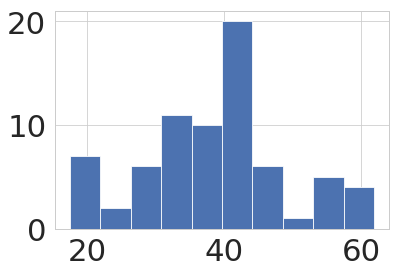

In [158]:
sample.rank_mean.hist()

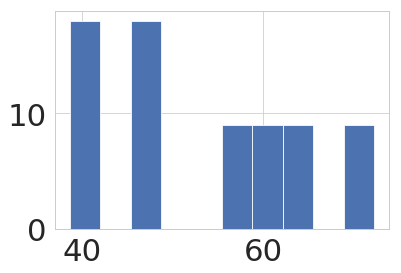

In [159]:
sample.start_rank_mean.hist()

In [160]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)

Ttest_relResult(statistic=-26.92000685351538, pvalue=5.4679203823990435e-39)

### test 5

In [161]:
sample = perf_compi[perf_compi.model == "LM"]

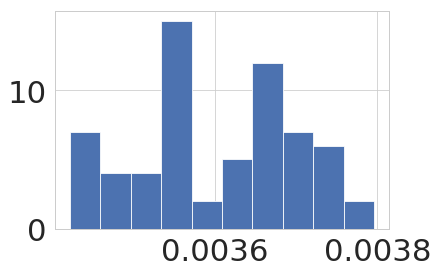

In [162]:
sample.mse.hist()

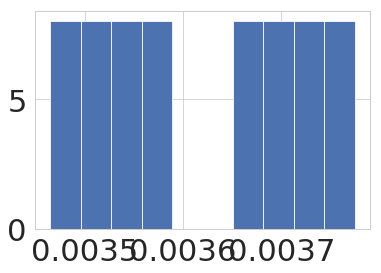

In [163]:
sample.start_mse.hist()

In [164]:
st.ttest_rel(sample.mse, sample.start_mse)

Ttest_relResult(statistic=-5.68236652143294, pvalue=3.65321059308665e-07)

### test 6

In [165]:
sample = perf_compi[perf_compi.model == "LM"]

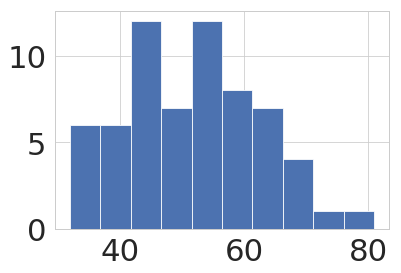

In [166]:
sample.rank_mean.hist()

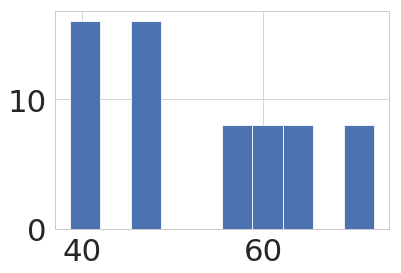

In [167]:
sample.start_rank_mean.hist()

In [168]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)

Ttest_relResult(statistic=-2.357452461448339, pvalue=0.02152012531214179)

### test 7

In [169]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

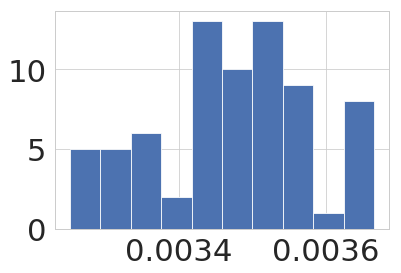

In [170]:
sample.mse.hist()

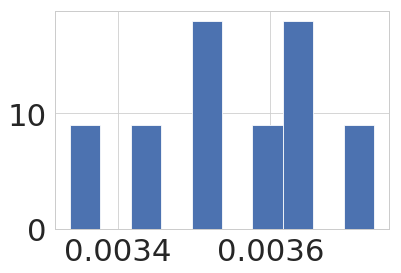

In [171]:
sample.glove_mse.hist()

In [172]:
st.ttest_rel(sample.mse, sample.glove_mse)

Ttest_relResult(statistic=-23.431867751506235, pvalue=3.880482793686937e-35)

### test 8

In [173]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

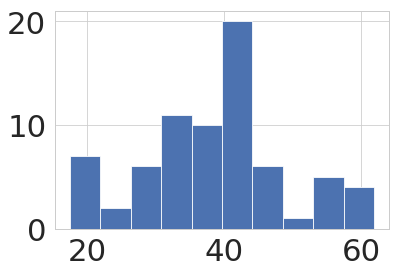

In [174]:
sample.rank_mean.hist()

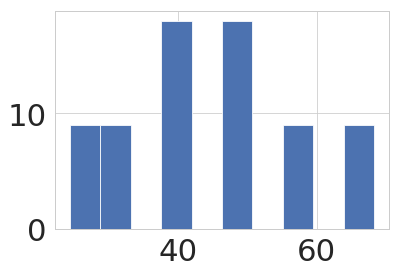

In [175]:
sample.glove_rank_mean.hist()

In [176]:
st.ttest_rel(sample.rank_mean, sample.glove_rank_mean)

Ttest_relResult(statistic=-12.117271239841596, pvalue=5.945909424804508e-19)

### test 9

In [177]:
sample = perf_compi[perf_compi.model == "LM_pos"]

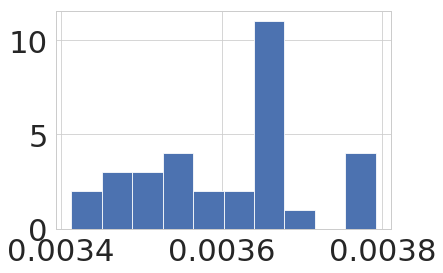

In [178]:
sample.mse.hist()

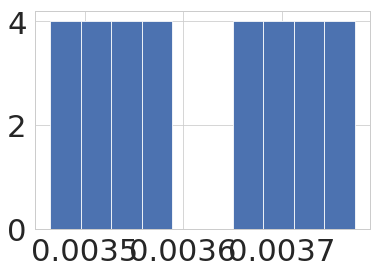

In [179]:
sample.start_mse.hist()

In [180]:
st.ttest_rel(sample.mse, sample.start_mse)

Ttest_relResult(statistic=-2.8964570213545775, pvalue=0.006863080024959731)

(0.0033, 0.0038)

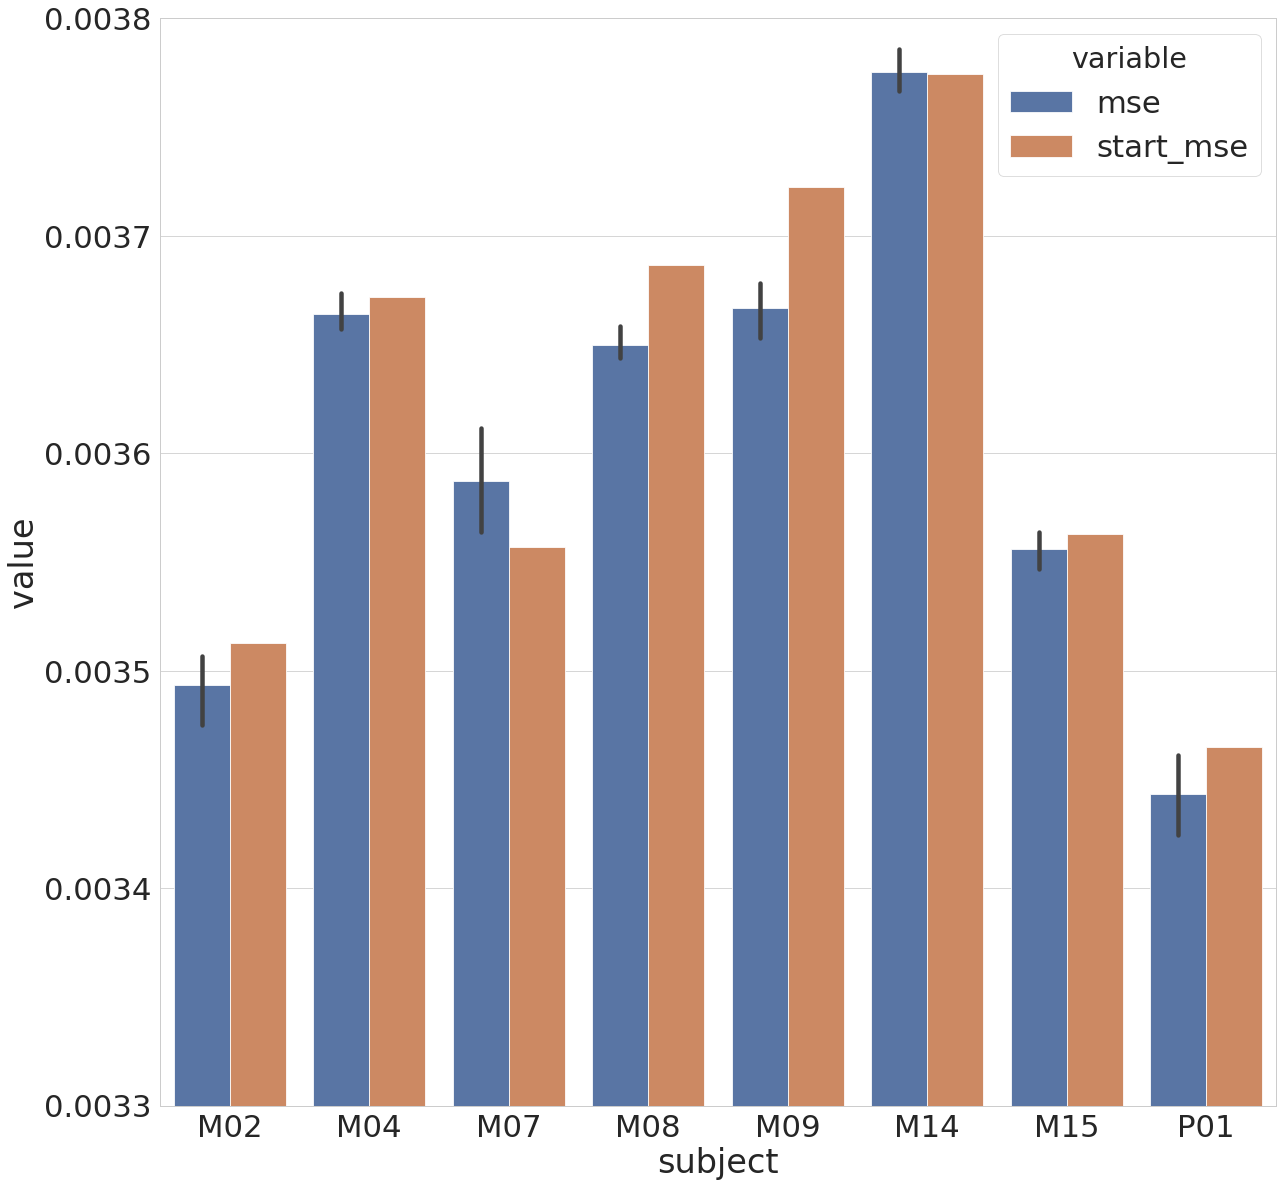

In [181]:
f = plt.figure(figsize=(20,20))
sns.barplot(data=pd.melt(sample, id_vars=["subject"], value_vars=["mse", "start_mse"]),
            x="subject", y="value", hue="variable")
plt.ylim((0.0033, 0.0038))

### test 10

In [182]:
sample = perf_compi[perf_compi.model == "LM_pos"]

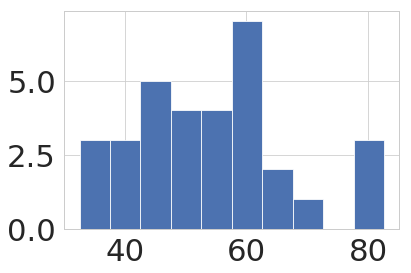

In [183]:
sample.rank_mean.hist()

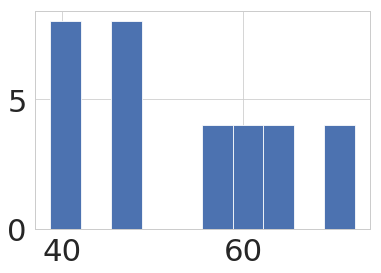

In [184]:
sample.start_rank_mean.hist()

In [185]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)

Ttest_relResult(statistic=2.103025744213817, pvalue=0.04367831344014221)